In [1]:
import graph_ruggedness_de
import matplotlib.pyplot as plt 
import networkx as nx
import numpy as np
import sequence_evolution
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import solution_space_simulation

QMetaType::registerTypedef: -- Type name 'PyQt_PyObject' previously registered as typedef of 'PyQt_PyObject' [1024], now registering as typedef of '' [-17958193].


### Sequence evolution simulation
The below cell simulates the simulation of amino acid sequences, drawing parameters from uniform distributions of realistic values. The cell has also been converted to functional code in `src.sequence_evolution.sample_sequences`. 

In [56]:
dir_dict = {}
prob_dict = {}
sample_dict = {}

sample_size = 1
for _ in tqdm(enumerate(range(sample_size))):
    try:

        num_nodes = int(np.random.uniform(50, 200))
        mean_branch_length = np.random.uniform(0.01, 0.5)
        std_dev_branch_length = np.random.uniform(0.001, 0.1)
        alpha = np.random.uniform(0.1, 0.5)
        model = random.choice(('WAG', 'LG'))
        rate_categoies = 4
        sequence_length = int(np.random.uniform(100, 600))

        sample_info = {
            'num_nodes' : num_nodes,
            'mean_branch_length' : mean_branch_length,
            'std_dev_branch_length' : std_dev_branch_length,
            'alpha' : alpha,
            'model' : model,
            'sequence_length' : sequence_length
        }

        seq_dict = sequence_evolution.sequence_evolution(num_nodes=num_nodes,
                                                        mean_branch_length=mean_branch_length,
                                                        std_dev_branch_length=std_dev_branch_length,
                                                        alpha=alpha,
                                                        model=model,
                                                        rate_categories=rate_categoies,
                                                        sequence_length=sequence_length
                                                        )
        seq_ls = list(seq_dict.values())
        values = [0]*len(seq_ls)
        G = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                            values=values)
    except: 
        continue

G_1 = graph_ruggedness_de.compute_elementary_landscape(G=G, n=1)
G_10 = graph_ruggedness_de.compute_elementary_landscape(G=G, n=10)
G_50 = graph_ruggedness_de.compute_elementary_landscape(G=G, n=50)
G_100 = graph_ruggedness_de.compute_elementary_landscape(G=G, n=100)

Computing OHE dictionary.: 20it [00:00, 281496.91it/s]
Adding nodes to graph.: 199it [00:00, 9815.56it/s]


Computing all vs. all OHE distance matrix.
Done.
Fitting all vs. all OHE distance model.
Done.


Adding KNN edges.: 199it [00:00, 96281.75it/s]
1it [00:02,  2.93s/it]


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_18988/3669067035.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)


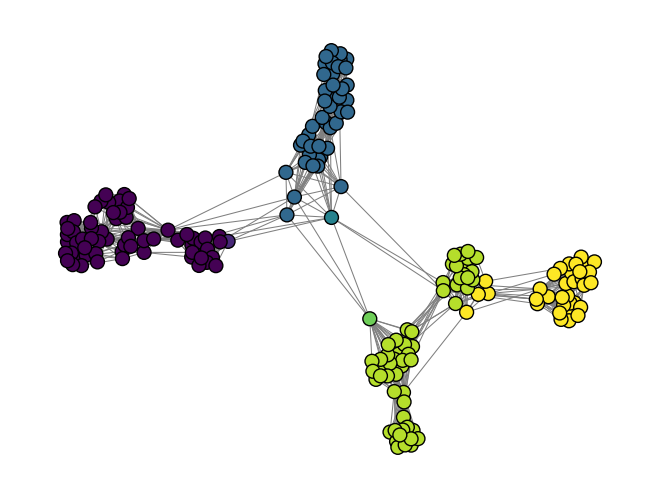

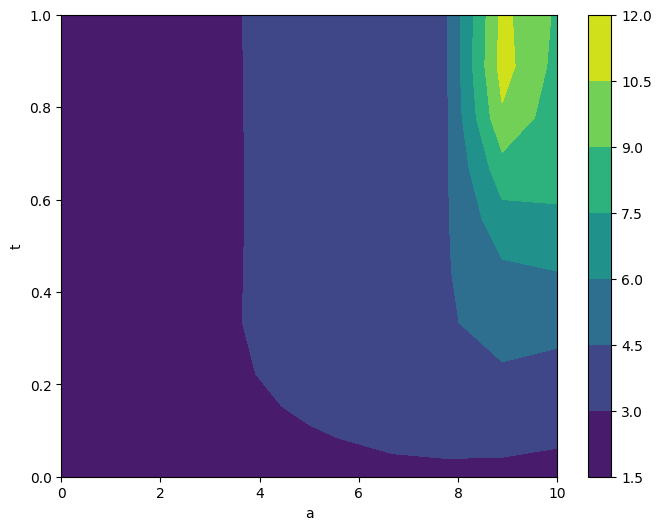

In [64]:
def normalize(values):
    min_val = min(values)
    max_val = max(values)
    
    if max_val == min_val:
        return [0] * len(values) 
    
    return [(x - min_val) / (max_val - min_val) for x in values]

G_c = G_1.copy()

values = [node[1]['value'] for node in G_c.nodes(data=True)]
values = normalize(values)
viridis = plt.cm.get_cmap('viridis', 10)
node_colors = [viridis((value - min(values)) / (max(values) - min(values))) for value in values]

nx.draw(G_c, node_color=node_colors, with_labels=False, edgecolors='black', node_size=100, width=0.75, edge_color='grey')
plt.show()

a_vals = np.linspace(0, 10, 10)
t_vals = np.linspace(0, 1, 10)

de_dict = {}

for i in a_vals:
    for j in t_vals:
        
        transformed_values = [solution_space_simulation.transform(fitness=value, a=i, t=j) for value in values]
        for idx, (node, data) in enumerate(G_c.nodes(data=True)):
            data['value'] = transformed_values[idx]

        de_dict[(i, j)] = graph_ruggedness_de.compute_dirichlet_energy(G=G_c)


a = np.array([key[0] for key in de_dict.keys()])
j = np.array([key[1] for key in de_dict.keys()])
z = np.array(list(de_dict.values()))

# Reshaping data for contour plot (assuming the data forms a grid)
# Here, we assume x and y values form a mesh grid
x_unique = np.unique(a)
y_unique = np.unique(j)
X, Y = np.meshgrid(x_unique, y_unique)
Z = z.reshape(len(y_unique), len(x_unique))

# Plotting the contour plot
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, Z, cmap='viridis')
plt.colorbar(cp)
plt.xlabel('a')
plt.ylabel('t')
plt.show()